<a href="https://colab.research.google.com/github/GaneshKumar508/Computer-networks-/blob/main/AI_Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                            confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sns.set(style="whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['cardio_train.csv']), sep=';')
print("Data loaded successfully!")
print("Shape:", df.shape)
display(df.head())

Saving cardio_train.csv to cardio_train.csv
Data loaded successfully!
Shape: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
df.drop_duplicates(inplace=True)
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)
df['age_years'] = (df['age'] / 365.25).round().astype(int)
swap_mask = df['ap_lo'] > df['ap_hi']
df.loc[swap_mask, ['ap_lo', 'ap_hi']] = df.loc[swap_mask, ['ap_hi', 'ap_lo']].values
df = df[(df['height'] >= 100) & (df['height'] <= 230)]
df = df[(df['weight'] >= 30) & (df['weight'] <= 300)]
df = df[(df['ap_hi'] >= 50) & (df['ap_hi'] <= 300)]
df = df[(df['ap_lo'] >= 30) & (df['ap_lo'] <= 200)]
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
print("Cleaning done. New shape:", df.shape)
display(df.describe().T.head(10))

Cleaning done. New shape: (68748, 14)


,count,mean,std,min,25%,50%,75%,max
age,68748.0,19464.540743,2467.986086,10798.0,17657.0,19701.0,21324.0,23713.0
gender,68748.0,1.348723,0.476570,1.0,1.0,1.0,2.0,2.0
height,68748.0,164.395313,7.978740,100.0,159.0,165.0,170.0,207.0
weight,68748.0,74.124148,14.306593,30.0,65.0,72.0,82.0,200.0
ap_hi,68748.0,126.682973,16.703913,60.0,120.0,120.0,140.0,240.0
ap_lo,68748.0,81.311791,9.481319,30.0,80.0,80.0,90.0,182.0
cholesterol,68748.0,1.364782,0.679009,1.0,1.0,1.0,2.0,3.0
gluc,68748.0,1.226072,0.572044,1.0,1.0,1.0,1.0,3.0
smoke,68748.0,0.087988,0.283280,0.0,0.0,0.0,0.0,1.0
alco,68748.0,0.053631,0.225289,0.0,0.0,0.0,0.0,1.0


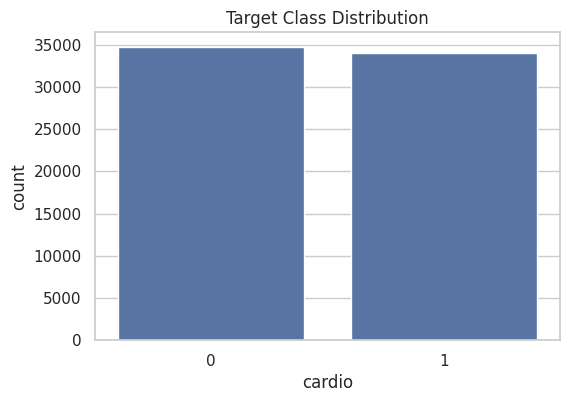

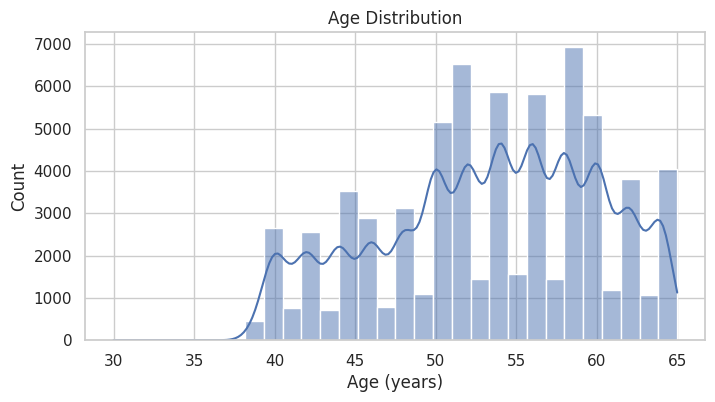

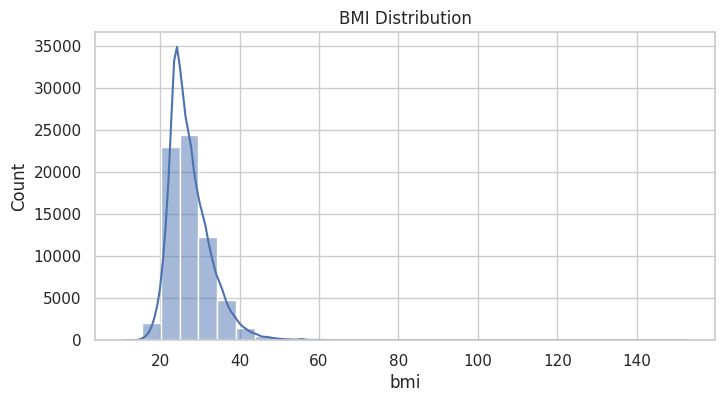

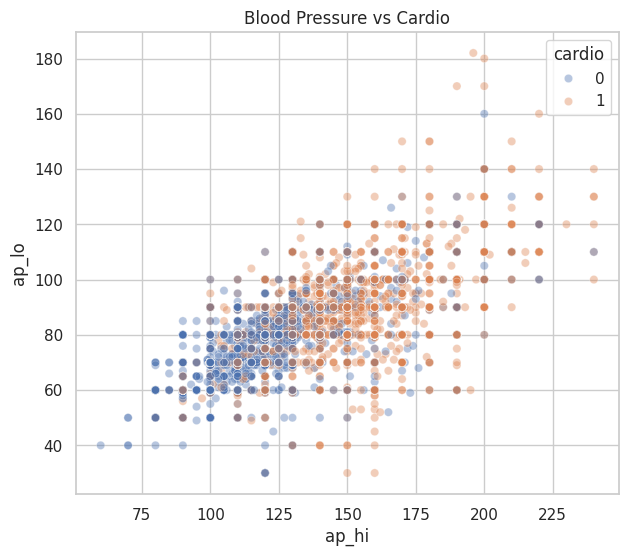

In [ ]:
#for Target Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='cardio', data=df)
plt.title("Target Class Distribution")
plt.show()
#for Age Distribution
plt.figure(figsize=(8,4))
sns.histplot(df['age_years'], bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age (years)")
plt.show()
#for BMI Distribution
plt.figure(figsize=(8,4))
sns.histplot(df['bmi'], bins=30, kde=True)
plt.title("BMI Distribution")
plt.show()
#for BP and Cardio
plt.figure(figsize=(7,6))
sns.scatterplot(x='ap_hi', y='ap_lo', hue='cardio', data=df, alpha=0.4)
plt.title("Blood Pressure vs Cardio")
plt.show()

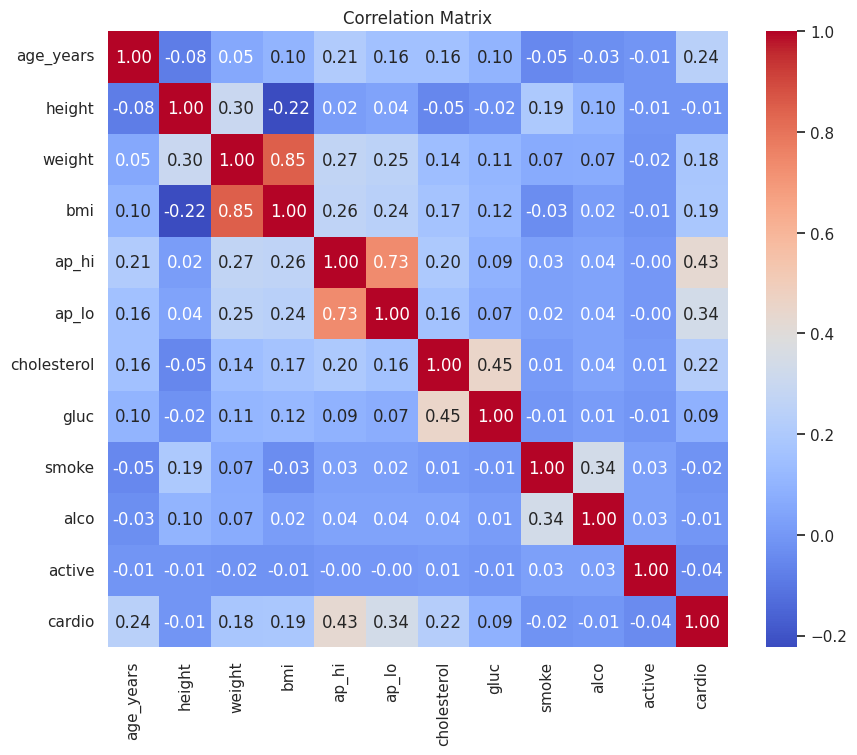

In [ ]:
#Correlation Matrix
features = ['age_years', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo',
            'cholesterol', 'gluc', 'smoke', 'alco', 'active']
features = [f for f in features if f in df.columns]
plt.figure(figsize=(10,8))
sns.heatmap(df[features + ['cardio']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
X = df[features]
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data split & scaled.")
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Data split & scaled.
Train shape: (54998, 11) Test shape: (13750, 11)


In [33]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = [acc, prec, rec, f1]

    print(f"\n{name}")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)
    print(confusion_matrix(y_test, y_pred))



Logistic Regression
Accuracy: 0.7292363636363637
Precision: 0.7586438402148372
Recall: 0.6642174871418075
F1: 0.7082974222361513
[[5507 1438]
 [2285 4520]]

SVM
Accuracy: 0.7330909090909091
Precision: 0.7674458283569356
Recall: 0.6609845701689934
F1: 0.7102479077846202
[[5582 1363]
 [2307 4498]]

KNN
Accuracy: 0.7003636363636364
Precision: 0.7021532901671435
Recall: 0.6852314474650992
F1: 0.6935891715008181
[[4967 1978]
 [2142 4663]]

Decision Tree
Accuracy: 0.6426181818181819
Precision: 0.6470222360441611
Recall: 0.6114621601763409
F1: 0.6287398005439709
[[4675 2270]
 [2644 4161]]

Random Forest
Accuracy: 0.7088
Precision: 0.7118438965360763
Recall: 0.6915503306392359
F1: 0.7015503875968992
[[5040 1905]
 [2099 4706]]


,Accuracy,Precision,Recall,F1
Logistic Regression,0.729236,0.758644,0.664217,0.708297
SVM,0.733091,0.767446,0.660985,0.710248
KNN,0.700364,0.702153,0.685231,0.693589
Decision Tree,0.642618,0.647022,0.611462,0.628740
Random Forest,0.708800,0.711844,0.691550,0.701550


/tmp/ipython-input-3087185498.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result_df.index, y=result_df['Accuracy'], palette="viridis")


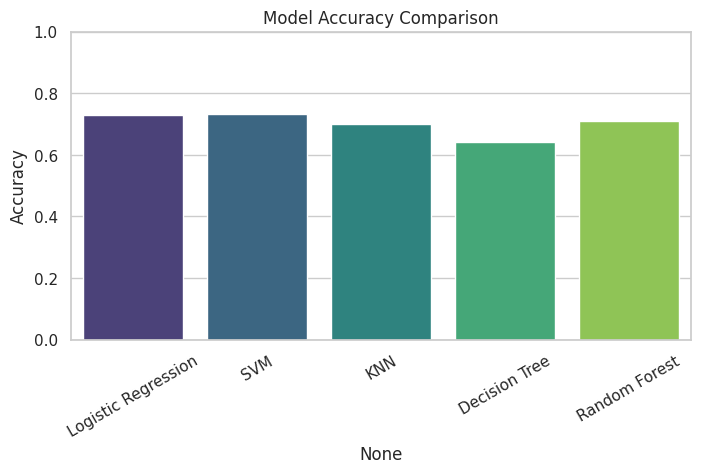

 Best model: SVM with F1=0.7102


In [34]:
result_df = pd.DataFrame(results, index=['Accuracy','Precision','Recall','F1']).T
display(result_df)

plt.figure(figsize=(8,4))
sns.barplot(x=result_df.index, y=result_df['Accuracy'], palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.xticks(rotation=30)
plt.show()

best_model_name = result_df['F1'].idxmax()
print(f" Best model: {best_model_name} with F1={result_df.loc[best_model_name, 'F1']:.4f}")


In [36]:
best_model = models[best_model_name]
joblib.dump(best_model, f"{best_model_name.replace(' ', '_').lower()}_model.joblib")
joblib.dump(scaler, "scaler_cardio.joblib")
print(" Model and scaler saved in Colab working directory.")


 Model and scaler saved in Colab working directory.
